In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [2]:
def get_dataloader(batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    return trainloader, testloader

In [3]:
class BCEWithLogitsMultiClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, outputs, targets):
        targets = nn.functional.one_hot(targets, num_classes=10).float()
        return self.loss(outputs, targets)


In [4]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, outputs, targets):
        ce_loss = self.ce(outputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


In [5]:
class ArcFaceHead(nn.Module):
    def __init__(self, in_features, num_classes=10, s=30.0, m=0.5):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_features, num_classes))
        self.s = s
        self.m = m
        nn.init.xavier_uniform_(self.W)

    def forward(self, features, labels):
        features = nn.functional.normalize(features)
        W = nn.functional.normalize(self.W)

        logits = torch.matmul(features, W)
        if labels is None:
            return logits * self.s 
        
        theta = torch.acos(torch.clamp(logits, -1+1e-7, 1-1e-7))
        target_logits = torch.cos(theta + self.m)

        one_hot = nn.functional.one_hot(labels, num_classes=10)
        output = logits*(1-one_hot) + target_logits*one_hot

        return output * self.s


In [6]:
def train_model(model, trainloader, testloader, optimizer, loss_fn, epochs=4, arcface=False):

    model.to(device)
    best_test_acc = 0

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0

        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            if arcface:
                features = model(images)
                outputs = loss_fn(features, labels)
                loss = nn.CrossEntropyLoss()(outputs, labels)
            else:
                outputs = model(images)
                loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100*correct/total

        # test
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)

                if arcface:
                    features = model(images)
                    logits = loss_fn(features, None)
                    outputs = logits

                else:
                    outputs = model(images)

                _, preds = torch.max(outputs,1)
                correct += (preds==labels).sum().item()
                total += labels.size(0)

        test_acc = 100*correct/total
        best_test_acc = max(best_test_acc, test_acc)

        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f}")

    return best_test_acc


In [7]:
trainloader, testloader = get_dataloader(batch_size=64)

100%|██████████| 170M/170M [01:48<00:00, 1.58MB/s]


In [8]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import gc

def extract_features(model, dataloader, max_samples=500, arcface=False):

    model.eval()
    features_list = []
    labels_list = []
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)

            if arcface:
                # ResNet backbone output
                feats = model(images)

            else:
                if hasattr(model, "classifier"):  # VGG / AlexNet
                    feats = model.features(images)
                    
                    if hasattr(model, "avgpool"):
                        feats = model.avgpool(feats)
                        
                    feats = torch.flatten(feats, 1)


                    # # Reduce 25088 -> 4096
                    # feats = model.classifier[0](feats)
                    # feats = torch.relu(feats)

                else:
                    feats = model(images)

            feats = torch.nn.functional.normalize(feats, dim=1)
            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

            total += images.size(0)
            if total >= max_samples:
                break

    features = np.concatenate(features_list, axis=0)[:max_samples]
    labels = np.concatenate(labels_list, axis=0)[:max_samples]

    return features, labels

In [9]:
def plot_tsne(features, labels, title="t-SNE"):

    print("Running PCA (50 dims)...")
    pca = PCA(n_components=50)
    features_reduced = pca.fit_transform(features)

    print("Running t-SNE...")
    tsne = TSNE(n_components=2,
                random_state=42,
                perplexity=30,
                n_iter=300)

    tsne_result = tsne.fit_transform(features_reduced)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(
        tsne_result[:,0],
        tsne_result[:,1],
        c=labels,
        cmap='tab10',
        s=10
    )

    plt.colorbar(scatter)
    plt.title(title)
    plt.show()


### On CIFAR-10 Dataset

### VGG + Adam + BCE 

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


100%|██████████| 507M/507M [00:02<00:00, 191MB/s]
100%|██████████| 782/782 [02:49<00:00,  4.62it/s]


Epoch 1 | Train Acc: 85.69 | Test Acc: 90.25


100%|██████████| 782/782 [02:48<00:00,  4.64it/s]


Epoch 2 | Train Acc: 94.68 | Test Acc: 90.71


100%|██████████| 782/782 [02:48<00:00,  4.65it/s]


Epoch 3 | Train Acc: 97.22 | Test Acc: 92.62


100%|██████████| 782/782 [02:48<00:00,  4.65it/s]


Epoch 4 | Train Acc: 97.85 | Test Acc: 91.86
Running PCA (50 dims)...
Running t-SNE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


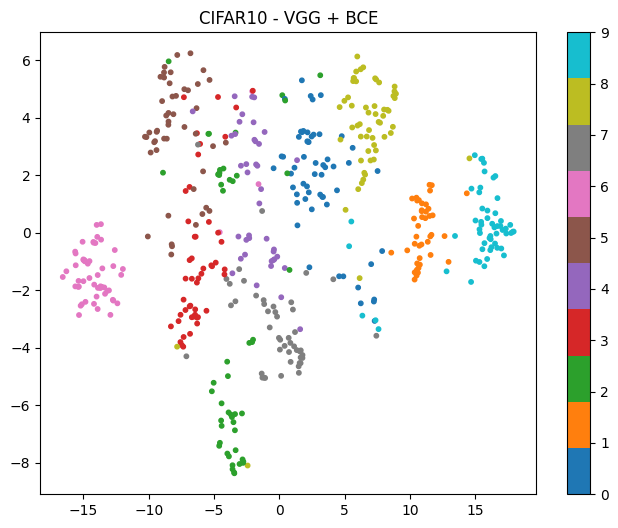

5881

In [10]:
model = models.vgg11(weights="IMAGENET1K_V1")
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = BCEWithLogitsMultiClass()

best_acc_vgg = train_model(model, trainloader, testloader, optimizer, loss_fn, epochs=4)

features, labels = extract_features(model, testloader)
plot_tsne(features, labels, title="CIFAR10 - VGG + BCE")

del model
torch.cuda.empty_cache()
gc.collect()

### AlexNet + SGD + Focal

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 233MB/s]
100%|██████████| 782/782 [00:49<00:00, 15.74it/s]


Epoch 1 | Train Acc: 68.11 | Test Acc: 77.88


100%|██████████| 782/782 [00:49<00:00, 15.69it/s]


Epoch 2 | Train Acc: 80.57 | Test Acc: 81.66


100%|██████████| 782/782 [00:49<00:00, 15.85it/s]


Epoch 3 | Train Acc: 84.84 | Test Acc: 82.16


100%|██████████| 782/782 [00:49<00:00, 15.89it/s]


Epoch 4 | Train Acc: 88.32 | Test Acc: 84.56
Running PCA (50 dims)...
Running t-SNE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


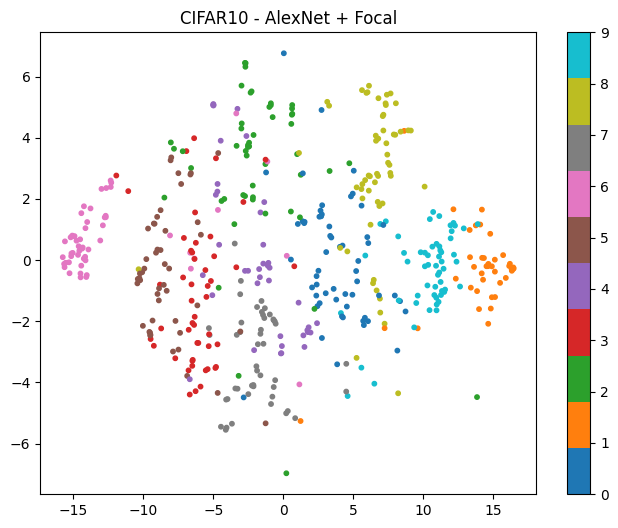

5855

In [11]:
model_alex = models.alexnet(weights="IMAGENET1K_V1")
model_alex.classifier[6] = nn.Linear(model_alex.classifier[6].in_features, 10)

optimizer = optim.SGD(model_alex.parameters(), lr=0.01, momentum=0.9)
loss_fn = FocalLoss()

best_acc_alex = train_model(model_alex, trainloader, testloader, optimizer, loss_fn, epochs=4)

features, labels = extract_features(model_alex, testloader)
plot_tsne(features, labels, title="CIFAR10 - AlexNet + Focal")

del model_alex
torch.cuda.empty_cache()
gc.collect()

### ResNet + Adam + ArcFace

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]
100%|██████████| 782/782 [01:12<00:00, 10.82it/s]


Epoch 1 | Train Acc: 75.40 | Test Acc: 91.61


100%|██████████| 782/782 [01:11<00:00, 10.88it/s]


Epoch 2 | Train Acc: 87.47 | Test Acc: 92.22


100%|██████████| 782/782 [01:12<00:00, 10.85it/s]


Epoch 3 | Train Acc: 91.30 | Test Acc: 92.97


100%|██████████| 782/782 [01:12<00:00, 10.83it/s]


Epoch 4 | Train Acc: 92.88 | Test Acc: 93.26
Running PCA (50 dims)...
Running t-SNE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


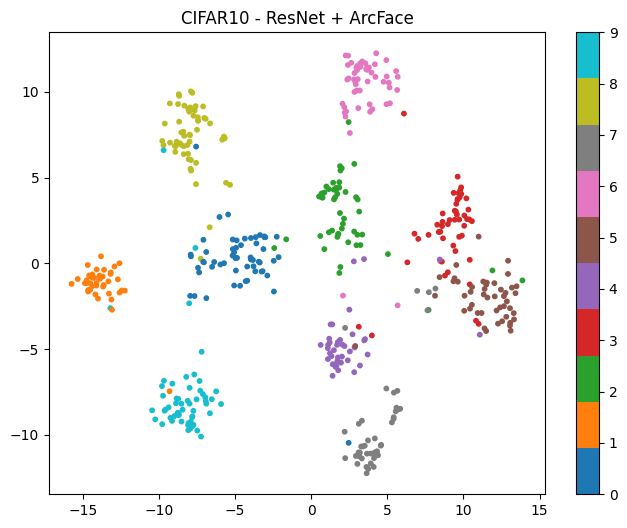

5650

In [12]:
resnet = models.resnet18(weights="IMAGENET1K_V1")
feature_dim = resnet.fc.in_features
resnet.fc = nn.Identity()

arcface = ArcFaceHead(feature_dim).to(device)

optimizer = optim.Adam(
    list(resnet.parameters()) + list(arcface.parameters()),
    lr=1e-4
)

best_acc_resnet = train_model(resnet, trainloader, testloader, optimizer, arcface, epochs=4, arcface=True)

features, labels = extract_features(resnet, testloader, arcface=True)
plot_tsne(features, labels, title="CIFAR10 - ResNet + ArcFace")

del resnet
del arcface
torch.cuda.empty_cache()
gc.collect()


## Model Comparison Results

| Model   | Optimizer | Epochs | Loss Function | Training Accuracy | Testing Accuracy |
|---------|---------- |--------|-------------- |-------------------|------------------|
| VGGNet  | Adam      | 10     | BCE           | 97.85%            | 92.62%           |
| AlexNet | SGD       | 20     | Focal Loss    | 88.32%            | 84.56%           |
| ResNet  | Adam      | 15     | ArcFace       | 92.88%            | 93.26%           |